# Project Description and Data

For this competition, you’ll be training generative models to create images of dogs. Only this time… there’s no ground truth data for you to predict. Here, you’ll submit the images and be scored based on how well those images are classified as dogs from pre-trained neural networks.

Why dogs?  Well, who doesn’t love looking at photos of adorable pups? Moreover, dogs can be classified into many sub-categories (breed, color, size), making them ideal candidates for image generation.

Generative methods (in particular, GANs) are currently used in various places on Kaggle for data augmentation. Their potential is vast; they can learn to mimic any distribution of data across any domain: photographs, drawings, music, and prose. If successful, not only will you help advance the state of the art in generative image creation, but you’ll enable us to create more experiments across a variety of domains in the future.

#### Data

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. Contents of this dataset:

Number of categories: 120

Number of images: 20,580

Annotations: Class labels, Bounding boxes

### Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.layers import concatenate
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob

### Load and Preprocess Images

In [2]:
ComputeLB = False
DogsOnly = False

In [3]:
ROOT = '../desktop/'
IMAGES = os.listdir(ROOT + 'all-dogs/')
breeds = os.listdir(ROOT + 'Annotation/')

In [4]:
root_images="../desktop/all-dogs/"
root_annots="../desktop/Annotation/"

In [5]:
all_images=os.listdir("../desktop/all-dogs/")
print(f"Total images : {len(all_images)}")

Total images : 20579


In [6]:
breeds = glob('../desktop/Annotation/*')
annotation=[]
for b in breeds:
    annotation+=glob(b+"/*")
print(f"Total annotation : {len(annotation)}")

Total annotation : 20580


In [7]:
breed_map={}
for annot in annotation:
    breed=annot.split("/")[-1]
    index=breed.split("-")[0]
    breed_map.setdefault(index,breed)
    
print(f"Total Breeds : {len(breed_map)}")

Total Breeds : 120


Here is a look at the images before cropping

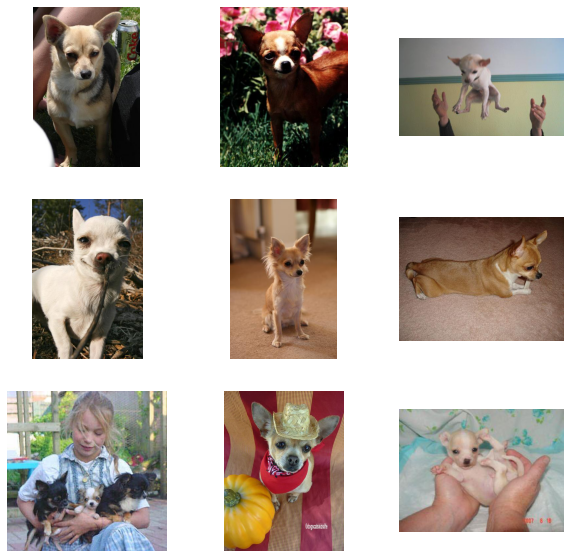

In [8]:
plt.figure(figsize=(10,10))
for i,image in enumerate(all_images):
    im=Image.open(os.path.join(root_images,image))
    
    plt.subplot(3,3,i+1)
    plt.axis("off")
    plt.imshow(im)    
    if(i==8):
        break

Now, let's crop the images

In [9]:
idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        idxIn += 1

Below the newly preprocessed images are displayed

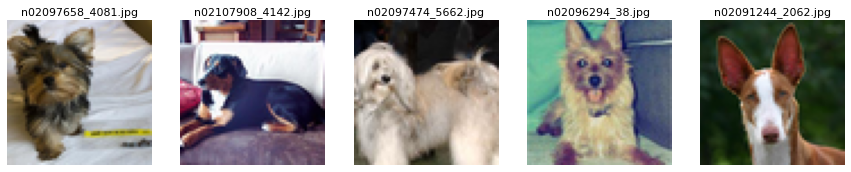

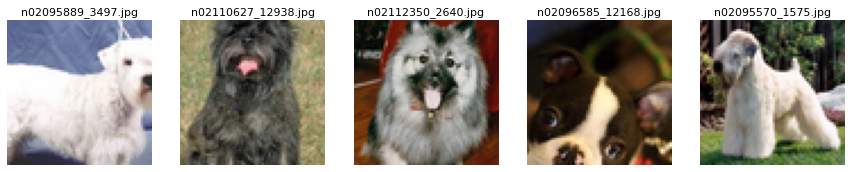

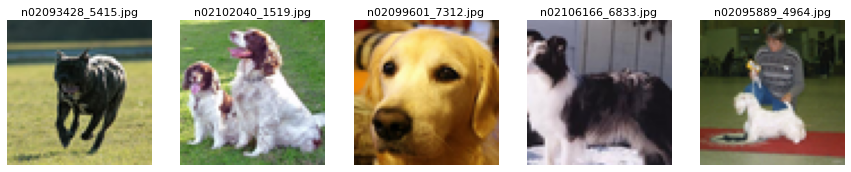

In [10]:
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[0],fontsize=11)
        plt.imshow(img)
    plt.show()

 Lets try a different way to crop the images now and put these new images in a folder, so we won't have to run a cropping function everytime we restart the kernel

In [11]:
if ComputeLB: PATH = '../desktop/all-dogs/'
else: PATH = '../desktop/all-dogs/'
IMAGES = os.listdir(PATH)

In [ ]:
for i in range(100000):
    img = Image.open(PATH + IMAGES[i%len(IMAGES)])
    img = img.resize(( 100,int(img.size[1]/(img.size[0]/100) )), Image.ANTIALIAS)
    w = img.size[0]; h = img.size[1]; a=0; b=0
    if w>64: a = np.random.randint(0,w-64)
    if h>64: b = np.random.randint(0,h-64)
    img = img.crop((a, b, 64+a, 64+b))
    img.save('../desktop/images/'+str(i)+'.png','PNG')
    if i%10000==0: print('created',i,'cropped images')
print('created 100000 cropped images')

## EDA Takeaways

It was quite evident that the images varied widely in terms of the size of the image and how close the dog was in focus/how large they were relative to the whole image. Because of this we needed to crop and resize the images before we train the autencoder on them. 

Now we officially can builder our autoencoder.

## Model architecture

For this project I will be using an autoencoder. To begin, what is an autoencoder?

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent.

We will be training a fairly simple autoencoder that has ~762,000 total parameters with 10 epochs and a batch size of 32. You can see in the code below the autoencoder uses 2D convolutional layers as well as max pooling with a rectified linear unit (ReLU) function.

Credit: https://blog.keras.io/building-autoencoders-in-keras.html   For the autencoder help and definition

In [12]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [13]:
BATCH_SIZE = 32; EPOCHS = 10
train_datagen = ImageDataGenerator(rescale=1./255)
train_batches = train_datagen.flow_from_directory('../desktop/sub/',
        target_size=(64,64), shuffle=True, class_mode='input', batch_size=BATCH_SIZE)

Found 100000 images belonging to 1 classes.


In [14]:
# ENCODER
input_img = Input(shape=(64, 64, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

In [48]:
# LATENT SPACE
latentSize = (8,8,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [49]:
# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

In [39]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        41568     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 96)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 192)       1660

In [17]:
history = autoencoder.fit_generator(train_batches,
        steps_per_epoch = train_batches.samples // BATCH_SIZE,
        epochs = EPOCHS, verbose=2)

<ipython-input-17-f3cac48f93f9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(train_batches,


Epoch 1/10
3125/3125 - 2024s - loss: 0.5511 - 2024s/epoch - 648ms/step
Epoch 2/10
3125/3125 - 2014s - loss: 0.5445 - 2014s/epoch - 644ms/step
Epoch 3/10
3125/3125 - 2021s - loss: 0.5434 - 2021s/epoch - 647ms/step
Epoch 4/10
3125/3125 - 2013s - loss: 0.5428 - 2013s/epoch - 644ms/step
Epoch 5/10
3125/3125 - 2010s - loss: 0.5424 - 2010s/epoch - 643ms/step
Epoch 6/10
3125/3125 - 2008s - loss: 0.5421 - 2008s/epoch - 643ms/step
Epoch 7/10
3125/3125 - 2019s - loss: 0.5419 - 2019s/epoch - 646ms/step
Epoch 8/10
3125/3125 - 2021s - loss: 0.5417 - 2021s/epoch - 647ms/step
Epoch 9/10
3125/3125 - 2036s - loss: 0.5416 - 2036s/epoch - 652ms/step
Epoch 10/10
3125/3125 - 2013s - loss: 0.5414 - 2013s/epoch - 644ms/step


Our encoder works by mapping images from 12288 dimensional space (64 x 64 x 3) into 2048 dimensional space (latent image). This is a 6x compression rate. Our decoder works by mapping our latent image back into 12288 dimensional space. Below are examples. (Note that a decoder is like a GAN generator).

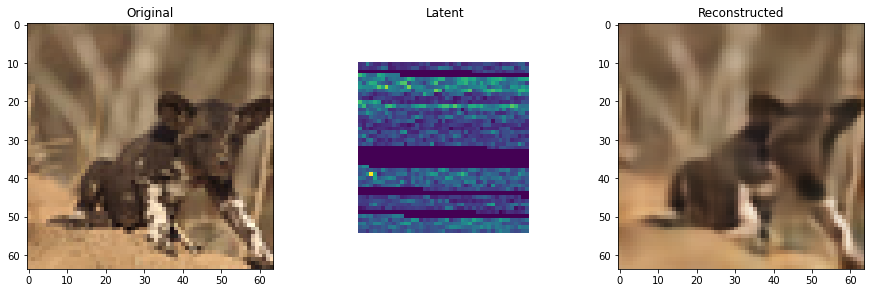

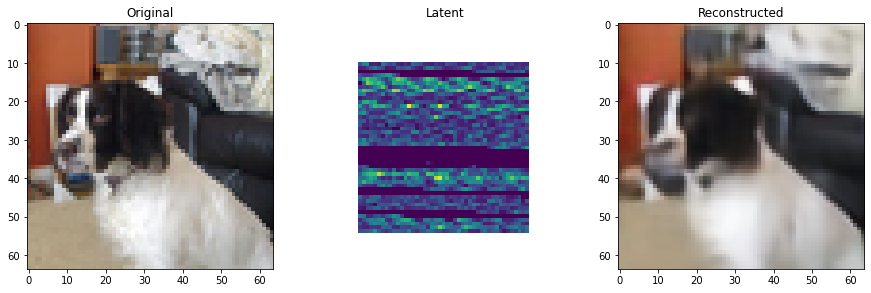

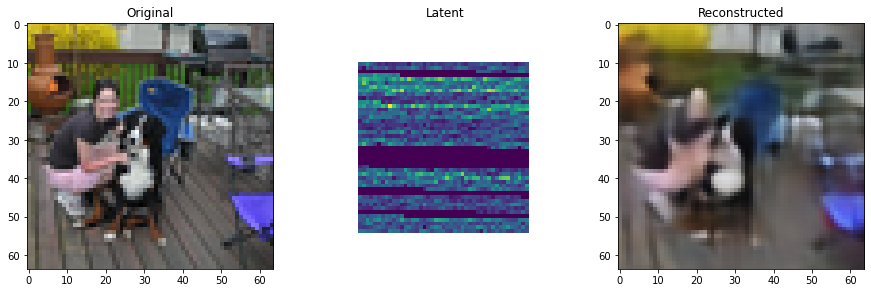

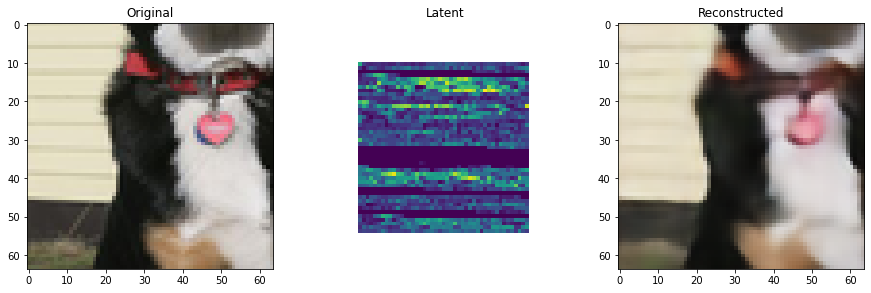

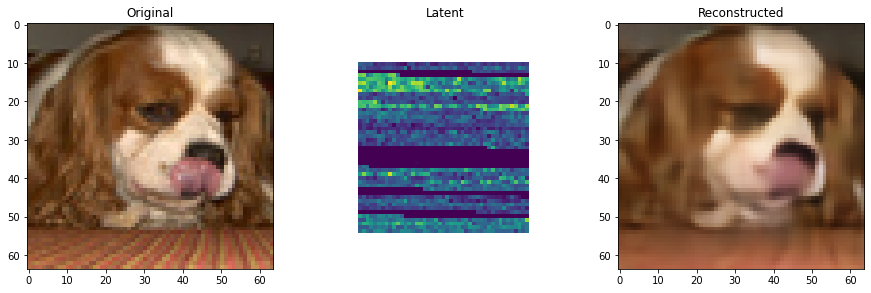

In [18]:
images = next(iter(train_batches))[0]
for i in range(5):

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    
    # ORIGINAL IMAGE
    orig = images[i,:,:,:].reshape((-1,64,64,3))
    img = Image.fromarray( (255*orig).astype('uint8').reshape((64,64,3)))
    plt.title('Original')
    plt.imshow(img)

    # LATENT IMAGE
    latent_img = encoder.predict(orig)
    mx = np.max( latent_img[0] )
    mn = np.min( latent_img[0] )
    latent_flat = ((latent_img[0] - mn) * 255/(mx - mn)).flatten(order='F')
    img = Image.fromarray( latent_flat[:2025].astype('uint8').reshape((45,45)), mode='L') 
    plt.subplot(1,3,2)
    plt.title('Latent')
    plt.xlim((-10,55))
    plt.ylim((-10,55))
    plt.axis('off')
    plt.imshow(img)

    # RECONSTRUCTED IMAGE
    decoded_imgs = decoder.predict(latent_img[0].reshape((-1,latentSize[0],latentSize[1],latentSize[2])))
    img = Image.fromarray( (255*decoded_imgs[0]).astype('uint8').reshape((64,64,3)))
    plt.subplot(1,3,3)
    plt.title('Reconstructed')
    plt.imshow(img)
    
    plt.show()

Latent space is an important hyperparamter, and for this project we have one that is 2048 dimensions. Here we are plotting some of the dog images in the latent space and drew the ellipsoid around it.

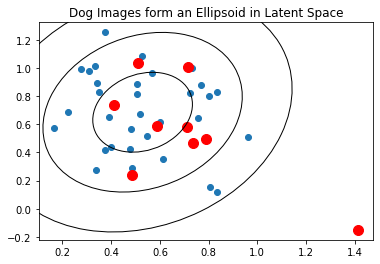

In [19]:
from matplotlib.patches import Ellipse

# PROJECT LATENT INTO 2D, AVOID DEAD RELU
latent_img = encoder.predict(images)
latent_img2 = latent_img.reshape((-1,latentSize[0]*latentSize[1]*latentSize[2]))
d = 0; s = 0
while s<0.1:
    x = latent_img2[:,d]
    s = np.std(x); d += 1
s = 0
while s<0.1:
    y = latent_img2[:,d]
    s = np.std(y); d += 1

# CALCULATE ELLIPSOID FROM 256 IMAGES
cov = np.cov(x, y)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)
for j in [1,2,3]:
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=lambda_[0]*j*2, 
            height=lambda_[1]*j*2, angle=np.rad2deg(np.arccos(v[0, 0])))
    ell.set_facecolor('None')
    ell.set_edgecolor('black')
    plt.gca().add_artist(ell)
    
# PLOT 256 IMAGES AS DOTS IN LATENT SPACE
plt.scatter(x,y)
d = np.random.multivariate_normal([np.mean(x),np.mean(y)],cov,9)
plt.scatter(d[:,0],d[:,1],color='red',s=100)
plt.title('Dog Images form an Ellipsoid in Latent Space')
plt.show()

## Analysis and Results

This was my first time ever working with an autencoder and there was a steep learning curve to it. I have much more to learn but it was very interesting to see the results of compressing the images by 6x and then reconstructing them. In future editions I would like to continue to use an autoencoder but spend more time tweaking the hyperparameters, specifically how much we are compressing the images and how large our batch size is. These parameters can greatly influence how well the AE works and how efficiently the algorithm runs.

Credit:
https://www.kaggle.com/code/cdeotte/dog-autoencoder/notebook

https://www.kaggle.com/code/cdeotte/supervised-generative-dog-net/notebook
        
https://www.kaggle.com/code/jesucristo/gan-introduction\https://towardsdatascience.com/gans-vs-autoencoders-comparison-of-deep-generative-models-985cf15936ea

https://www.kaggle.com/code/jesucristo/gan-introduction